# Advanced usage: growth
Text to be added

In [1]:
import numpy as np
# Jupyter magic
%load_ext autoreload
%autoreload 2

In [2]:
from monarch.egg import Monarch

# Initialize model
input_file = '/Users/pimoomen/PycharmProjects/monarch/input_files/canine_vo'
beats = Monarch(input_file)

# Simulate growth
beats.let_it_grow()

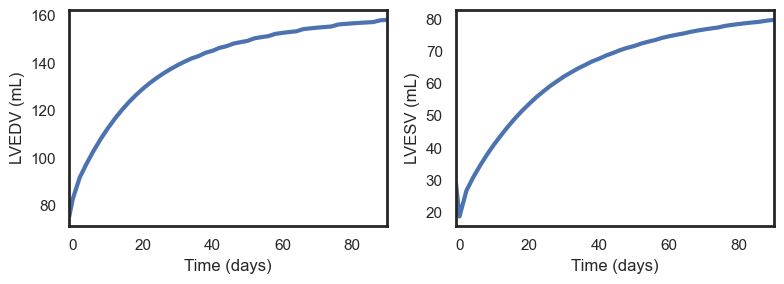

In [3]:
from monarch import metamophoses as meta

meta.plot_growth(beats, ["LVEDV", "LVESV"], ["mL", "mL"])

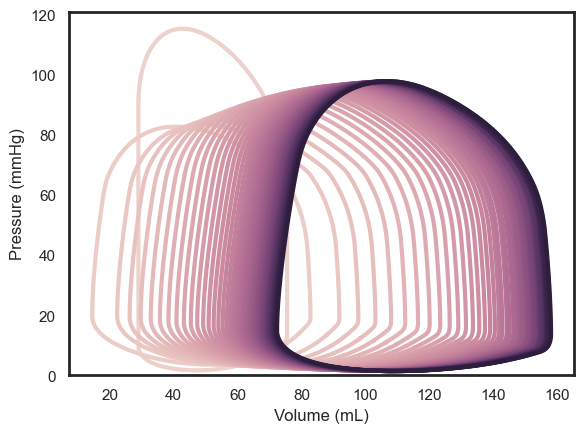

In [4]:
meta.pv_loop_growth(beats)

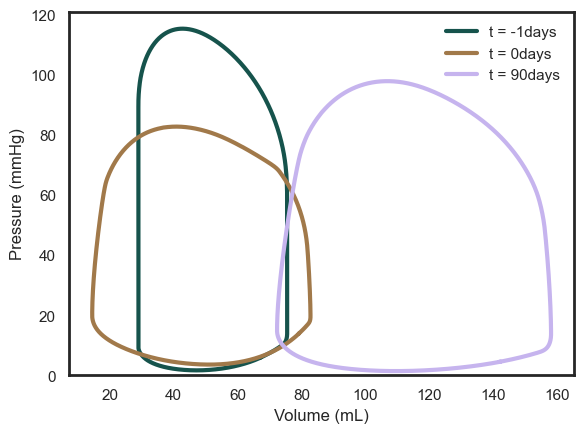

In [5]:
meta.pv_loop_growth(beats, index=(0, 1, -1))